# **Sentiment Analysis with Disaster Tweets ⛈🙂**

En este notebook, se utilizó el dataset "Natural Language Processing with Disaster Tweets" de Kaggle con el objetivo de clasificar tweets en dos categorías: desastres reales o no. Se analiza la eficacia del modelo de clasificación en la detección de tweets de desastres hecho en la iteración previa, con una característica adicional. Se ha evaluado el impacto de esta nueva característica, neg_score, y se ha observado que no mejora el rendimiento del modelo.

**Authors:**
- [Andrea Ramirez](https://github.com/Andrea-gt)
- [Adrian Flores](https://github.com/adrianRFlores)

***

## **(1) Import Libraries** ⬇️

In [247]:
#!pip install unidecode

In [248]:
#!pip install nlpaug

In [249]:
#!pip install wordcloud

In [250]:
# Data manipulation and visualization
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import kurtosis, skew, probplot
from sklearn.metrics import mean_absolute_error, mean_squared_error
import statsmodels.api as sm
import itertools
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from unidecode import unidecode
import tensorflow as tf
from tensorflow import keras
from google.colab import files

# Standard libraries
import warnings
warnings.filterwarnings('ignore')

# ===== ===== Reproducibility Seed ===== =====
# Set a fixed seed for the random number generator for reproducibility
random_state = 42

# Set matplotlib inline
%matplotlib inline

# Set default figure size
plt.rcParams['figure.figsize'] = (6, 4)

# Define custom color palette
palette = sns.color_palette("viridis", 12)

# Set the style of seaborn
sns.set(style="whitegrid")

## **(2) Data Upload** 📄

In [251]:
df = pd.read_csv('data/train.csv')
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


## **(3) Exploratory Analysis** 🔎

### **(1) Descripción General de los Datos**

In [252]:
# Print the number of records in the DataFrame
print("The given dataset has", df.shape[0], "registers and", df.shape[1], "columns.")

The given dataset has 7613 registers and 5 columns.


**Observaciones 💡 -->**

> - El conjunto de datos original cuenta con 7613 registros y 5 columnas, lo que indica que tiene una dimensión relativamente pequeña. Cada uno de los 7613 registros representa una observación única, mientras que las 5 columnas corresponden a diferentes características o variables medidas para cada observación, incluyendo el texto de un tweet, una palabra clave asociada y la ubicación desde donde se envió, aunque estas últimas dos pueden estar en blanco en algunas ocasiones.

**Fuente:** [Página oficial de Kaggle](https://www.kaggle.com/competitions/nlp-getting-started/data?select=train.csv)

In [253]:
# Basic information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


Como se puede observar, se cuentan con 5 columnas o features en este conjunto de datos, siendo estas las que se describen a continuación.

- **id**: un identificador único para cada tweet.
- **text**: el texto del tweet.
- **location**: la ubicación desde donde se envió el tweet (puede estar en blanco).
- **keyword**: una palabra clave particular del tweet (puede estar en blanco).
- **target**: en el archivo `train.csv` solamente, indica si un tweet es sobre un desastre real (`1`) o no (`0`).

### **(2) Clasificación de las Variables**

| **Nombre**    | **Descripción**                                             | **Tipo de variable**                     |
|---------------|-------------------------------------------------------------|------------------------------------------|
| **id**        | Un identificador único para cada tweet                      | Cuantitativa                             |
| **text**      | El texto del tweet                                          | Cualitativa (descriptiva)                |
| **location**  | La ubicación desde donde se envió el tweet                  | Cualitativa (descriptiva)                |
| **keyword**   | Una palabra clave particular del tweet                      | Cualitativa (descriptiva)                |
| **target**    | Indica si un tweet es sobre un desastre real o no           | Cualitativa (binaria)                    |

**Observaciones 💡 -->**

> - El conjunto de datos posee 3 variables cualitativas descriptivas y 1 de tipo binaria.
> - La última variable del conjunto de datos (id) es de tipo cuantitativo.

### **(3) Exploración y Limpieza Inicial de los Datos**

#### **(1) Preprocesamiento de los Datos**

In [254]:
df.drop(columns=['id'], inplace=True)

In [255]:
# Download the NLTK stopwords if not already available
nltk.download('stopwords')
# Initialize the PorterStemmer
stemmer = PorterStemmer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [256]:
# Get the list of stopwords from NLTK
stop_words = set(stopwords.words('english'))

In [257]:
# Function to remove stopwords and apply stemming
def preprocess_text(text):
    # Tokenize the text
    words = text.split()
    # Remove stopwords and apply stemming
    processed_words = [stemmer.stem(word) for word in words if word not in stop_words]
    # Reassemble the text
    return ' '.join(processed_words)

In [258]:
# Convert all entries to strings
df['text'] = df['text'].astype(str)
# Remove URLs
df['text'] = df['text'].str.replace(r'http\S+|www\S+|https\S+', '', case=False, regex=True)
# Convert to lowercase
df['text'] = df['text'].str.lower()
# Remove leading/trailing whitespaces
df['text'] = df['text'].str.strip()
# Remove special characters and punctuation (keeping letters, numbers, and spaces)
df['text'] = df['text'].str.replace(r'[^\w\s]', '', regex=True)
# Remove extra spaces
df['text'] = df['text'].str.replace(r'\s+', ' ', regex=True)
# Apply preprocessing (stopwords removal and stemming)
df['text'] = df['text'].apply(preprocess_text)

In [259]:
df.isnull().sum()

,0
keyword,61
location,2533
text,0
target,0


In [260]:
# Converting the column to a list
column_to_list = df['location'].unique().tolist()
# Convert all elements to strings to avoid TypeError
column_to_list_str = [str(location) for location in column_to_list]

# === WARNING ====
# The detailed listing of unique locations has been commented out to maintain a clean notebook interface.
# If a comprehensive view is required, please uncomment the following lines:
# print("Unique Locations:")
# print(", ".join(column_to_list_str))

print(f"\nTotal number of unique locations: {len(column_to_list_str)}")


Total number of unique locations: 3342


In [261]:
df = df.drop(['location'],axis=1)

In [262]:
# Drop rows where 'keyword' column has NaN values
df = df.dropna(subset=['keyword'])

In [263]:
# Check duplicate rows in dataset
df = df.drop_duplicates()
# Print the number of records in the DataFrame
print("The given dataset has", df.shape[0], "registers and", df.shape[1], "columns.")

The given dataset has 6940 registers and 3 columns.


**Observaciones 💡 -->**

> - Primero eliminaremos la columna `id`, ya que no aporta información significativa al conjunto de datos. Dado que cada registro corresponde a una observación única, esta columna no contribuye a la variabilidad o al análisis. Al eliminarla, reducimos la dimensionalidad, lo que puede mejorar la eficiencia de nuestro algoritmo y simplificar la interpretación posterior de este.

> - Continuamos el preprocesamiento con dos pasos cruciales para optimizar el análisis de texto: la aplicación de un stemmer y la eliminación de stopwords (o palabras vacías).


> - Continúa el preprocesamiento con la realización de varias transformaciones para limpiar y estandarizar el texto en la columna text. Primero, convertimos todas las entradas a cadenas de texto para asegurar la consistencia en el tipo de dato. A continuación, eliminamos URLs, que suelen introducir ruido sin aportar valor al análisis. También convertimos el texto a minúsculas y eliminamos los espacios en blanco al inicio y al final de las cadenas para mantener uniformidad. Luego, removemos caracteres especiales y signos de puntuación, dejando solo letras, números y espacios, lo que facilita el análisis posterior. Además, eliminamos espacios extra y normalizamos el texto quitando acentos.

> - La columna location presenta una cantidad considerable de datos faltantes, aproximadamente un 33% de las entradas son nulas. Además, estas ausencias no son uniformes, ya que algunas se representan con símbolos como '???' o contienen caracteres especiales que complican aún más su interpretación debido a que son entradas escritas por usuarios. Esta falta de consistencia en los datos, sumada al hecho de que la variable de ubicación podría introducir sesgos significativos en el modelo, nos lleva a concluir que es mejor eliminar esta columna.

> - Seguidamente se realiza imputaciones en la columna `keyword` al eliminar las entradas nulas, esto se justifica con el hecho de que estas entradas representan únicamente alrededor de un 0.9% de nuestros datos.

> - Como último paso del preprocesamiento, filtramos los valores duplicados en el conjunto de datos. Al eliminar duplicados, aseguramos que cada registro sea único, lo que mejora la integridad de los datos y optimiza la precisión del modelo al trabajar con un conjunto no redundante.

**Nota:**

  1.   El **stemmer** reduce las palabras a su raíz o forma básica, lo que permite agrupar diferentes variaciones de una misma palabra bajo una única representación. Esto no solo disminuye la dimensionalidad del conjunto de datos haciendo que sea más fácil procesar este, sino que también mejora la capacidad de los algoritmos para identificar patrones relevantes en el texto. [[Referencia]](https://www.geeksforgeeks.org/introduction-to-stemming/)

  2.   Por otro lado, la eliminación de **stopwords** filtra palabras comunes que, aunque frecuentes, aportan poco valor semántico al análisis, como "y", "el", "en", entre otras. Al excluir estas palabras, se enfoca el modelo en términos más significativos, lo que puede resultar en una mejora notable en la precisión y eficiencia del análisis textual. Sin embargo, el beneficio más grande es la reducción de dimensionalidad, permitiendo que el entrenamiento sea más rápido. [[Referencia]](https://towardsdatascience.com/text-pre-processing-stop-words-removal-using-different-libraries-f20bac19929a)

  3. Para algunas de las tareas de procesamiento de lenguaje natural descritas con anterioridad, se optó por implementar nltk, para más información por favor ingresar a la documentación oficial en el siguiente [enlace](https://www.nltk.org/).

#### **(2) Exploración de los Datos**

In [264]:
# Calculate the length of text entries in the 'text' column.
length = df["text"].apply(len)
# Display descriptive statistics of text lengths.
print("Training Set: Text Length Statistics")
print(length.describe())

Training Set: Text Length Statistics
count    6940.000000
mean       58.801729
std        22.872899
min         4.000000
25%        42.000000
50%        60.000000
75%        76.000000
max       127.000000
Name: text, dtype: float64


**Observaciones 💡 -->**

> - Este pequeño análisis de la longitud de los textos en el conjunto de datos nos permite descubrir varias características interesantes. Con un total de 7,001 registros, la longitud promedio de los textos es de aproximadamente 59 caracteres, lo que indica que la mayoría de las entradas son relativamente cortas. La desviación estándar es de aproximadamente 23 caracteres, lo que sugiere una variabilidad moderada en la longitud de los textos.

> - El rango de las longitudes varía significativamente, desde un mínimo de 3 caracteres hasta un máximo de 127 caracteres. El 50% de los textos tienen una longitud de 60 caracteres o menos, con el 25% de los textos por debajo de 41 caracteres y el 75% por debajo de 76 caracteres. Por ende, aunque la mayoría de los textos tienen una longitud similar, hay una presencia de textos mucho más cortos o más largos.

**Tablas de Frecuencia para Cada Columna -->**

In [265]:
# See what are the 10 most frequent values for each of the dataframe columns
for column in df.columns:
    frequency_values = df[column].value_counts().head(10)
    print("Top 10 most frequent values for column '{}':".format(column))
    for index, (value, frequency) in enumerate(frequency_values.items(), start=1):
        print("{:<5} {:<30} {:<10}".format(index, value, frequency))
    print("\n===============================================")

Top 10 most frequent values for column 'keyword':
1     fatalities                     45        
2     deluge                         42        
3     armageddon                     42        
4     damage                         41        
5     harm                           41        
6     evacuate                       40        
7     fear                           40        
8     body%20bags                    40        
9     twister                        40        
10    siren                          40        

Top 10 most frequent values for column 'text':
1     angri woman openli accus nema steal relief materi meant idp angri intern displac wom 2         
2     cindi noonancindynoonanheartbreak baltimor riot yahistor undergroundrailraod 2         
3     feel like sink low selfimag take quiz 2         
4     horribl sink feel youûªv home phone realis 3g whole time 2         
5     break obama offici gave muslim terrorist weapon use texa attack 2         
6     trafford c

**Word Cloud de Columna Text -->**

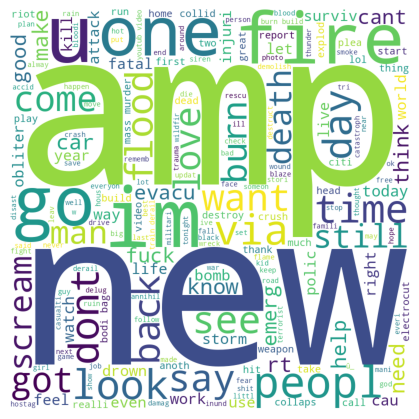

In [266]:
from wordcloud import WordCloud
# Initialize an empty string to store all keywords
comment_words = ''

# Iterate through the 'text' column
for val in df['text']:
    # Split the sentence into words (tokens) assuming the text is already clean
    tokens = val.split()  # This will split by whitespace

    # Join the tokens back into a single string and add to comment_words
    comment_words += " ".join(tokens) + " "

# Generate the word cloud using the concatenated string of tokens
wordcloud = WordCloud(width=800, height=800,
                      background_color='white',
                      stopwords=None,  # Stopwords are assumed to be already removed
                      min_font_size=10).generate(comment_words)

# Plot the WordCloud image
plt.figure(figsize=(6, 4), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)

# Show the plot
plt.show()

**Word Cloud de Columna Keyword-->**

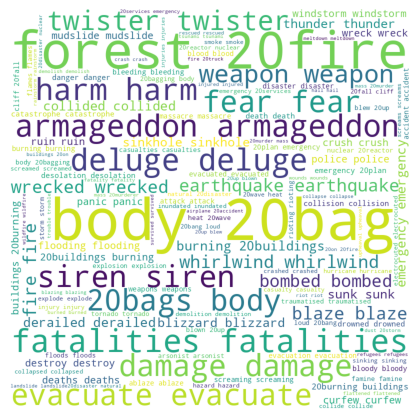

In [267]:
# Initialize an empty string to store all keywords
comment_words = ''

# Iterate through the 'keyword' column and concatenate the keywords into a single string
for val in df['keyword']:
    comment_words += (val + " ")

# Generate the word cloud using the concatenated string of keywords
wordcloud = WordCloud(width=800, height=800,
                      background_color='white',
                      stopwords=None,  # Adjust this if you have a list of stopwords to exclude
                      min_font_size=10).generate(comment_words)

# Plot the WordCloud image
plt.figure(figsize=(6, 4), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)

# Show the plot
plt.show()

**Análisis de Distribución de Target -->**

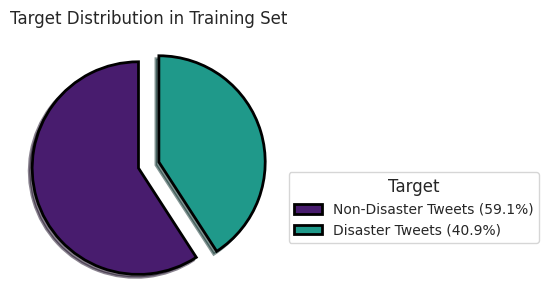

In [268]:
# Create a figure with a single subplot
fig, ax = plt.subplots(figsize=(6, 4), dpi=100)  # Use subplots() to get the Axes object
plt.tight_layout(pad=3.0)  # Add padding around the plot

# Calculate target counts and percentages
target_counts = df['target'].value_counts()
total_count = target_counts.sum()
labels = [f'Non-Disaster Tweets ({target_counts[0]/total_count:.1%})',
         f'Disaster Tweets ({target_counts[1]/total_count:.1%})']

# Define colors from the viridis palette
colors = [palette[0], palette[6]]  # Assign specific colors to each slice

# Plot pie chart for target distribution with customized colors
wedges, texts, autotexts = ax.pie(target_counts, autopct='%1.1f%%', startangle=90, colors=colors, wedgeprops=dict(linewidth=2, edgecolor='black'),
                                  shadow=True, explode=(0.1, 0.1))

# Set the title
ax.set_title('Target Distribution in Training Set')

# Remove the default labels (texts)
for text in texts:
    text.set_visible(False)
for autotext in autotexts:
    autotext.set_visible(False)

# Add a legend with a specific location and size
ax.legend(wedges, labels, title='Target', loc='best', bbox_to_anchor=(1, 0.5), fontsize='small')

# Display the plot
plt.show()

**Observaciones 💡 -->**

> - Como es posible observar, nuestras tablas de frecuencia muestran que el conjunto de datos está desbalanceado en términos de la variable 'target': el **valor 0** (que indica la ausencia de un desastre) aparece con mucha más frecuencia (4105 casos) que el **valor 1** (que indica la presencia de un desastre) con 2835 casos. Este desbalance podría afectar el rendimiento de nuestro modelo pero primero evaluaremos su desempeño antes de tomar decisiones.

> -  Para la columna keyword, esta simple tabla de frecuencia no nos dice lo suficiente así que haremos un análisis más profundo.

In [269]:
# Pairing 0's with their most frequent keywords
target_0_keywords = df[df['target'] == 0]['keyword'].value_counts().head(10)
print("Top 10 most frequent keywords for target '0':")
for index, (keyword, frequency) in enumerate(target_0_keywords.items(), start=1):
    print(f"{index:<5} {keyword:<30} {frequency:<10}")
print("\n===============================================")

# Pairing 1's with their most frequent keywords
target_1_keywords = df[df['target'] == 1]['keyword'].value_counts().head(10)
print("Top 10 most frequent keywords for target '1':")
for index, (keyword, frequency) in enumerate(target_1_keywords.items(), start=1):
    print(f"{index:<5} {keyword:<30} {frequency:<10}")

Top 10 most frequent keywords for target '0':
1     body%20bags                    39        
2     harm                           37        
3     armageddon                     37        
4     deluge                         36        
5     ruin                           36        
6     wrecked                        36        
7     twister                        35        
8     fear                           35        
9     siren                          35        
10    panic                          34        

Top 10 most frequent keywords for target '1':
1     evacuated                      31        
2     debris                         31        
3     earthquake                     30        
4     derailment                     29        
5     wildfire                       29        
6     nuclear%20disaster             28        
7     suicide%20bombing              28        
8     evacuation                     28        
9     buildings%20on%20fire          27    

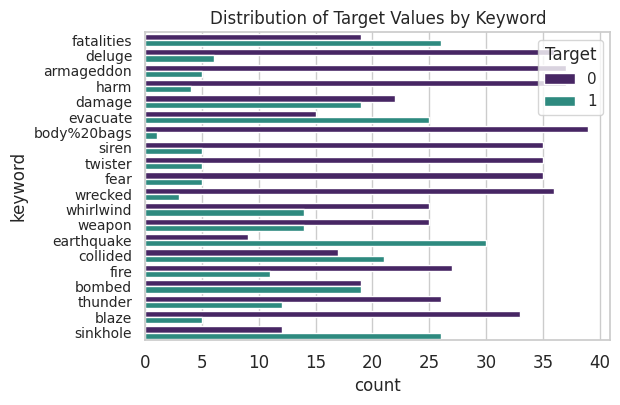

In [270]:
# Create a figure with increased size for better visual clarity
fig = plt.figure(figsize=(6, 4), dpi=100)  # Adjusted figsize for better visual clarity

# Group by 'keyword' and calculate mean target values
grouped_df = df.groupby('keyword')['target'].transform('mean')

# Sort DataFrame by calculated mean target values
sorted_df = df.assign(mean_target=grouped_df).sort_values(by='mean_target', ascending=False)

# Optional: Display only the top N keywords for better visibility
top_n = 20
top_keywords = sorted_df['keyword'].value_counts().index[:top_n]
filtered_df = sorted_df[sorted_df['keyword'].isin(top_keywords)]

# Create a count plot with horizontal bars
sns.countplot(y='keyword', hue='target', data=filtered_df, order=top_keywords, palette=colors)

# Customize plot appearance
plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=10)
plt.legend(title='Target', loc='upper right')
plt.title('Distribution of Target Values by Keyword')

# Display the plot
plt.show()

**Observaciones 💡 -->**

> - Se evidencia que para el target 0, los términos más frecuentes como "body bags" "harm" y "armageddon" están relacionados con eventos graves o de alta magnitud, pero en el contexto de la ausencia de un desastre, estos podrían estar mal clasificados o reflejar un contexto de preocupación general. Por otro lado, para el target 1, palabras como "evacuated" "debris" y "earthquake" se relacionan claramente con eventos de emergencia reales.

> - En general, los bigramas o trigramas consisten en obtener los tokens o palabras consecutivas. Esta técnica está más orientadas a aplicaciones como el análisis de sentimientos o la predicción de texto, pero se considera que podría llegar a aplicarse en este contexto. Para esto, no obstante, primero es importante adquirir ¡aún más información acerca de nuestro conjunto de datos! [[Referencia]](https://www.geeksforgeeks.org/generate-bigrams-with-nltk/)

**Consideración de N-gramas** <br>
**Observaciones 💡 -->**

> - No se generarán n-gramas en esta ocasión, ya que en el laboratorio anterior se determinó que no mejoran el desempeño del modelo, ya que no aportan información adicional al conjunto de datos. Por ende, no, no se considera que vagae la pena explorar bigramas o trigramas.

## **(4) Sentiment Analysis 😖 🔎**

### **(1) Clasificación de Palabras Según Sentimiento**

In [271]:
from nltk.sentiment import SentimentIntensityAnalyzer

In [272]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [273]:
sia = SentimentIntensityAnalyzer()

**Observaciones 💡 -->**

> - Como se puede observar en el código anterior, así como en el laboratorio previo y en los ejercicios anteriores, se implementará la librería NLTK para la clasificación de palabras y tweets en base a sentimiento, utilizando específicamente el módulo `SentimentIntensityAnalyzer`.

> - Nótese que se carga un dataset llamado `vader_lexicon`. VADER (Valence Aware Dictionary and sEntiment Reasoner) es una herramienta de análisis de sentimientos basada en un diccionario y reglas, diseñada específicamente para captar los sentimientos expresados en las redes sociales, aunque también funciona bien con textos de otros dominios. Al lector que le interese conocer más detalladamente su funcionamiento, por favor ingresar al siguiente enlace --> https://github.com/cjhutto/vaderSentiment

#### **(2) Clasificación de Tweets Sentimiento**

In [274]:
def classify_sentiment(text):
    # Get the sentiment scores for the input text
    score = sia.polarity_scores(text)

    # Check the compound score to classify the sentiment
    if score['compound'] >= 0.05:
        sentiment = 'positive'
    elif score['compound'] <= -0.05:
        sentiment = 'negative'
    else:
        sentiment = 'neutral'

    # Return both the sentiment classification and the neg score
    return sentiment, score['compound'], score['neg']

In [275]:
# Apply the classify_sentiment function to each row in the 'text' column
df[['sentiment', 'score', 'neg_score']] = df['text'].apply(classify_sentiment).apply(pd.Series)

In [276]:
# Display the DataFrame to verify the result
df.head()

,keyword,text,target,sentiment,score,neg_score
31,ablaze,bbcmtd wholesal market ablaz,1,neutral,0.0,0.0
32,ablaze,alway tri bring heavi metal rt,0,neutral,0.0,0.0
33,ablaze,africanbaz break newsnigeria flag set ablaz aba,1,neutral,0.0,0.0
34,ablaze,cri set ablaz,0,neutral,0.0,0.0
35,ablaze,plu side look sky last night ablaz,0,neutral,0.0,0.0


**Observaciones 💡 -->**

> - Se ha añadido una variable adicional que captura la "negatividad" de cada tweet, basada en los resultados del análisis de sentimiento realizado con NLTK. Se **espera** que esta variable permita una evaluación más detallada y cuantitativa de las emociones negativas expresadas en los tweets, proporcionando un recurso útil para permitirle al modelo entender mejor si se trata o no de un tweet de desastre.

#### **(3) Visualización de los Datos**

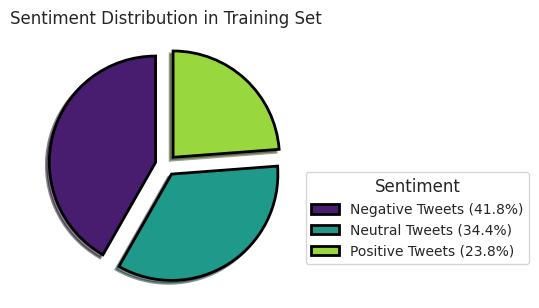

In [284]:
# Define colors from the viridis palette
colors = [palette[0], palette[6], palette[10]]  # Assign specific colors to each slice

# Create a figure with a single subplot
fig, ax = plt.subplots(figsize=(6, 4), dpi=100)  # Use subplots() to get the Axes object
plt.tight_layout(pad=3.0)  # Add padding around the plot

# Calculate target counts and percentages
sentiment_counts = df['sentiment'].value_counts()
total_count = sentiment_counts.sum()
labels = [f'Negative Tweets ({sentiment_counts[0]/total_count:.1%})',
         f'Neutral Tweets ({sentiment_counts[1]/total_count:.1%})', f'Positive Tweets ({sentiment_counts[2]/total_count:.1%})']

# Plot pie chart for target distribution with customized colors
wedges, texts, autotexts = ax.pie(sentiment_counts, autopct='%1.1f%%', startangle=90, colors=colors, wedgeprops=dict(linewidth=2, edgecolor='black'),
                                  shadow=True, explode=(0.1, 0.1, 0.1))

# Set the title
ax.set_title('Sentiment Distribution in Training Set')

# Remove the default labels (texts)
for text in texts:
    text.set_visible(False)
for autotext in autotexts:
    autotext.set_visible(False)

# Add a legend with a specific location and size
ax.legend(wedges, labels, title='Sentiment', loc='best', bbox_to_anchor=(1, 0.5), fontsize='small')

# Display the plot
plt.show()

**Observaciones 💡 -->**

> - **Tweets Negativos (41.8%)**: Una gran proporción de los tweets analizados muestra emociones negativas.

> - **Tweets Neutros (34.4%)**: Casi un tercio de los tweets no muestran una carga emocional clara, lo que sugiere que muchos mensajes son informativos o carecen de una opinión fuerte.

> - **Tweets Positivos (23.8%)**: La menor proporción de tweets positivos indica que las expresiones de satisfacción o emociones positivas son menos comunes.

> - Como se puede observar, en general no hay una distribución balanceada de emociones, ya que la mayoría de los tweets son negativos o neutrales, con una menor proporción de positivos, indicando un desequilibrio hacia la negatividad. En otras palabras, la distribución podría ser vista como desbalanceada en términos de sentimientos positivos.

**Top 10 tweets más negativos -->**

In [277]:
# Filter to include only 'negative' tweets
filtered_df = df[df['sentiment'] == 'negative']

# Sort the DataFrame by the 'score' column in descending order
df_sorted = filtered_df.sort_values(by='score')

# Select the top 10 rows with the highest negative scores
negative_tweets = df_sorted.head(10)

# Select only the columns you need: 'text', 'score', and 'target'
negative_tweets = negative_tweets[['text', 'score', 'target', 'neg_score']]

# Display the top 10 negative tweets
negative_tweets

,text,score,target,neg_score
7472,wreck wreck wreck wreck wreck wreck wreck wrec...,-0.9879,0,1.000
6980,stop fuck say ûïa whole ûnotherû sound fuck st...,-0.9618,0,0.662
2153,heard there two death murder chrissi kill adam...,-0.9595,0,0.683
1540,bomb crash loot riot emerg pipe bomb nuclear c...,-0.9538,1,0.550
2932,lake see dead fish poor littl guy wonder happe...,-0.9460,0,0.644
6930,cspan prez mr presid biggest terrorist troubl ...,-0.9442,1,0.585
7402,gunmen open fire bu near el salvador capit kil...,-0.9423,1,0.554
1808,man kill crash barrington hill hoffman estat m...,-0.9413,1,0.622
7398,gunmen kill four el salvador bu attack suspect...,-0.9403,1,0.572
6439,infograph least 20 turkish secur offici kill p...,-0.9371,1,0.567


**Observaciones 💡 -->**

> - Los tweets más negativos tienen puntuaciones de sentimiento muy bajas, indicando una fuerte carga negativa en el contenido.

> - La variable **neg_score** muestra altos niveles de negatividad, alcanzando valores cercanos a 1.0, lo que refuerza la intensidad negativa en estos tweets.

> - En general, vemos que los temas en estos tweets incluyen desastres, violencia y situaciones graves, lo que contribuye a la alta negatividad observada.

> - Finalmente, la mayoría de los tweets con alto neg_score también están etiquetados como desastres (target = 1), confirmando que los sentimientos negativos son prevalentes en este grupo.

**Top 10 tweets más postivos -->**

In [286]:
# Filter to include only 'positive' tweets
filtered_df = df[df['sentiment'] == 'positive']

# Sort the DataFrame by the 'score' column
df_sorted = filtered_df.sort_values(by='score', ascending=False )

# Select the top 10 rows with the highest positive scores
positive_tweets = df_sorted.head(10)

# Select only the columns you need: 'text', 'score', and 'target'
positive_tweets = positive_tweets[['text', 'score', 'target', 'neg_score']]

# Display the top 10 positive tweets
positive_tweets

,text,score,target,neg_score
6992,check want twister ticket vip experi see shani...,0.9682,0,0.000
3382,batfanuk enjoy show today great fun emerg non ...,0.9565,0,0.000
3163,batfanuk enjoy show today great fun emerg non ...,0.9565,0,0.000
6292,todayûª storm pass let tomorrowûª light greet ...,0.9432,1,0.000
4710,morning_jo reinc presssec joe ur smart u run 4...,0.9371,0,0.000
5033,first impress glad hat man leav lieu interest ...,0.9313,0,0.000
1856,love love love rememb first crush,0.9186,0,0.099
3792,justinejayyy ohgod xd didnt mean p fire truck ...,0.9106,0,0.000
4957,justintrudeau respect world best job recoveri ...,0.9100,0,0.000
3816,what cool teen becom like call digit first res...,0.9081,0,0.000


**Observaciones 💡 -->**

> - Vemos que en este caso, los valores en la columna `neg_score` son muy bajos (cercanos a 0), lo que sugiere que no contienen contenido negativo significativo.

> -  La mayoría de los tweets con bajo neg_score también están etiquetados como no desastres (target = 0), confirmando que los sentimientos positivos son prevalentes en este grupo.

> - Finalmente, los tweets como "today storm pass let tomorrow light greet" muestran un enfoque esperanzador incluso en contextos de desastres.

<div class="alert alert-block alert-info">
<b>Nota:</b> En general, nótese que los tweets de la categoría que indica que habla de un desastre real poseen un neg_score mucho más alto que su contraparte, indicando o sugiriendo que estos son más negativos que los de la categoría de no desastre.</div>

## **(5) Model Generation: LSTM Approach**

> - Para entrenar una red neuronal que clasifique datos secuenciales, se puede optar por una red LSTM (Long Short-Term Memory). Este tipo de red permite procesar datos en secuencia y realizar predicciones basadas en cada paso de la secuencia. Dado que el texto también es una forma de dato secuencial, las redes LSTM  son herramientas muy efectivas ppara este tipo de situaciones, ya que son capaces de captar dependencias y contextos a lo largo de la secuencia. En base a esto se justifica la decisión de implementar un modelo LSTM [[Referencia]](https://www.mathworks.com/help/deeplearning/ug/classify-sequence-data-using-lstm-networks.html).

In [294]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, Dense, LSTM, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

### **(1) Embedding and Tokenization of Tweets**

In [295]:
texts = df['text'].values
labels = df['target'].values
neg_scores = df['neg_score'].values

In [296]:
# Tokenization and Padding
max_words = 10000  # Maximum number of unique words
max_len = 127      # Maximum length of sequences

In [297]:
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)

In [298]:
sequences = tokenizer.texts_to_sequences(texts)

In [299]:
X = pad_sequences(sequences, maxlen=max_len)

In [300]:
# Convert neg_scores to a 2D array and pad with zeros to match the max_len
neg_scores = np.array(neg_scores).reshape(-1, 1)  # Reshape to be a column vector
neg_scores_padded = np.zeros((X.shape[0], 1))  # Initialize with zeros
neg_scores_padded[:neg_scores.shape[0], 0] = neg_scores.flatten()  # Add neg_scores

# Combine the padded sequences and neg_scores
X = np.hstack((X, neg_scores_padded))

**Observaciones 💡 -->**

En este paso, se realiza un preprocesamiento del texto para que pueda ser ingresado al modelo. Este proceso incluye:

1. **Tokenización del Texto**: Primero, se crea un tokenizador que convierte el texto en una secuencia de números. Cada palabra en el texto es reemplazada por un número único, según su frecuencia en el conjunto de datos. Esto permite al modelo trabajar con datos numéricos en lugar de texto crudo.

2. **Conversión a Secuencias**: Una vez tokenizado el texto, se transforma en secuencias de números. Cada secuencia representa un texto en forma de una lista de números, donde cada número corresponde a una palabra específica en el vocabulario.

3. **Relleno de Secuencias**: Las secuencias resultantes se ajustan para que todas tengan la misma longitud. Esto es necesario porque los modelos de aprendizaje automático requieren entradas de tamaño uniforme. Se agrega relleno a las secuencias más cortas y se recorta a las más largas para garantizar que todas tengan la misma dimensión.
**Consideraciones Adicionales**

4. **Integración de `neg_score`: Se convierte la lista de puntuaciones de negatividad en un array 2D y se ajusta para coincidir con las dimensiones de las secuencias de texto preprocesadas, añadiendo relleno cuando es necesario. Luego, se combinan las secuencias de texto y las puntuaciones de negatividad en un solo array, creando un conjunto de datos enriquecido que incluye tanto las características textuales como las puntuaciones emocionales, lo que puede mejorar el rendimiento del modelo.

Se ha decidido descartar la columna `keyword` del conjunto de datos. La razón es que la palabra en esta columna ya está incluida en el texto del tweet, por lo que no proporciona información adicional. Al no considerarla, se reduce la dimensionalidad del conjunto de datos sin perder la información relevante, ya que el texto del tweet ya contiene la información necesaria.

Además, el objetivo final es **"recibir el texto de un tweet sin preprocesar y determinar si se refiere a un desastre natural o no"**. En otras palabras, el problema se resuelve a partir de un texto plano, y por ende no tiene sentido incluir la columna `keyword`.

### **(2) Data Splitting Process**

In [302]:
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=random_state)

In [303]:
# Print the shapes of the train and test sets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (5552, 128)
X_test shape: (1388, 128)
y_train shape: (5552,)
y_test shape: (1388,)


### **(3) Model Development and Creation**

In [304]:
epochs = 15  # For better result increase the epochs
batch_size = 64

In [306]:
# Define the model
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=16, input_length=max_len))
model.add(Bidirectional(LSTM(16, return_sequences=True)))
model.add(Bidirectional(LSTM(16)))
model.add(Dense(18, activation='relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(9, activation='relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(1, activation='sigmoid'))  # Binary classification

# Explicitly build the model
model.build(input_shape=(None, max_len))

In [307]:
# Define the optimizer
opt = keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999)

In [308]:
# Compile the model
model.compile(optimizer = opt, loss = "binary_crossentropy" , metrics=["accuracy"])

In [309]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 127, 16)             │         160,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, 127, 32)             │           4,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ (None, 32)                  │           6,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 18)                  │             594 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 18)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 18)                  │              72 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 9)                   │             171 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 9)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 9)                   │              36 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              10 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 171,379 (669.45 KB)

 Trainable params: 171,325 (669.24 KB)

 Non-trainable params: 54 (216.00 B)

**Observaciones 💡 -->**

El modelo definido es una arquitectura para el procesamiento de datos secuenciales, especialmente diseñada para clasificación binaria. La red comienza con una capa de Embedding, que transforma las secuencias de números en vectores de dimensión 16, capturando las representaciones semánticas de las palabras en un espacio denso. Luego, se emplea una capa Bidirectional LSTM con 16 unidades, seguida de otra capa Bidirectional LSTM con la misma cantidad de unidades, para capturar dependencias tanto a corto como a largo plazo en las secuencias de texto. Estas capas LSTM son bidireccionales, lo que permite que la red considere la información de la secuencia en ambas direcciones.

Posteriormente, se añaden capas Dense con 18 y 9 neuronas, respectivamente, utilizando la activación ReLU para introducir no linealidades y ayudar al modelo a aprender representaciones complejas. Cada una de estas capas está seguida de una capa de Dropout con una tasa del 50% y una capa de BatchNormalization, lo que ayuda a prevenir el sobreajuste y a normalizar las activaciones para mejorar la estabilidad del entrenamiento. Finalmente, la red culmina en una capa densa con una sola neurona y activación sigmoid, que realiza la clasificación binaria, determinando si el texto se refiere a un desastre natural o no. La estructura del modelo está explícitamente construida para manejar entradas de longitud fija, definida por max_len.

##### **(1) Entrenamiento**

In [310]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)

In [311]:
# Fit the model
history = model.fit(X_train, y_train,
                    epochs = epochs, validation_data = (X_test, y_test), batch_size = X_train.shape[0] // batch_size,
                    callbacks=[early_stopping])

Epoch 1/15
65/65 ━━━━━━━━━━━━━━━━━━━━ 24s 229ms/step - accuracy: 0.5145 - loss: 0.8728 - val_accuracy: 0.5879 - val_loss: 0.6896
Epoch 2/15
65/65 ━━━━━━━━━━━━━━━━━━━━ 19s 208ms/step - accuracy: 0.5046 - loss: 0.8431 - val_accuracy: 0.5879 - val_loss: 0.6865
Epoch 3/15
65/65 ━━━━━━━━━━━━━━━━━━━━ 21s 210ms/step - accuracy: 0.5747 - loss: 0.6949 - val_accuracy: 0.5879 - val_loss: 0.6857
Epoch 4/15
65/65 ━━━━━━━━━━━━━━━━━━━━ 21s 223ms/step - accuracy: 0.5956 - loss: 0.6853 - val_accuracy: 0.5879 - val_loss: 0.6845
Epoch 5/15
65/65 ━━━━━━━━━━━━━━━━━━━━ 14s 215ms/step - accuracy: 0.5875 - loss: 0.6867 - val_accuracy: 0.5879 - val_loss: 0.6835
Epoch 6/15
65/65 ━━━━━━━━━━━━━━━━━━━━ 14s 213ms/step - accuracy: 0.5900 - loss: 0.6839 - val_accuracy: 0.5879 - val_loss: 0.6826
Epoch 7/15
65/65 ━━━━━━━━━━━━━━━━━━━━ 14s 214ms/step - accuracy: 0.5928 - loss: 0.6818 - val_accuracy: 0.5879 - val_loss: 0.6815
Epoch 8/15
65/65 ━━━━━━━━━━━━━━━━━━━━ 20s 214ms/step - accuracy: 0.6051 - loss: 0.6789 - val_accu

**Observaciones 💡 -->**

> - El entrenamiento del nuevo modelo muestra una evolución en el rendimiento a lo largo de las 15 épocas. Al principio, la precisión del modelo en el conjunto de entrenamiento se incrementa lentamente, alcanzando un punto alto del 61.2% en la última época, mientras que la pérdida disminuye de 0.8728 a 0.6683. Sin embargo, la precisión en el conjunto de validación muestra un patrón menos consistente, comenzando en 58.79% y fluctuando ligeramente, con una mejora notable en la última época, alcanzando un 63.33%. La pérdida de validación también mejora al final, bajando de 0.6896 a 0.6600.

> - Estos resultados sugieren que, aunque el modelo mejora su rendimiento en el conjunto de entrenamiento, la precisión de validación sigue un patrón más errático, con una mejora al final. Esto podría indicar que el modelo está empezando a generalizar mejor a los datos de validación en las últimas épocas.

##### **(2) Evaluación de Desempeño**

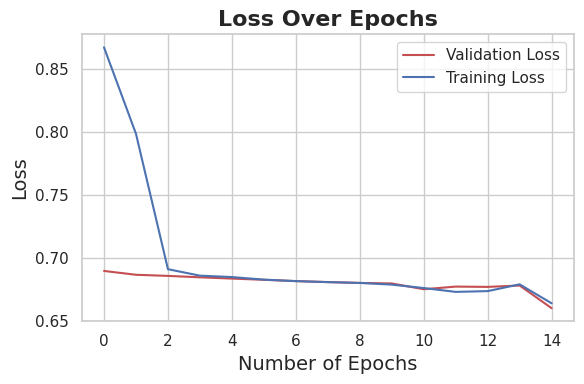

In [312]:
plt.figure(figsize=(6, 4))
# Plot train and validation loss with a color palette
sns.lineplot(x=range(len(history.history['val_loss'])), y=history.history['val_loss'], color='r', label="Validation Loss")
sns.lineplot(x=range(len(history.history['loss'])), y=history.history['loss'], color='b', label="Training Loss")
# Add titles and labels with improved styling
plt.title("Loss Over Epochs", fontsize=16, weight='bold')
plt.xlabel("Number of Epochs", fontsize=14)
plt.ylabel("Loss", fontsize=14)
# Add gridlines and legend
plt.grid(True)
plt.legend()
# Show the plot
plt.tight_layout()
plt.show()

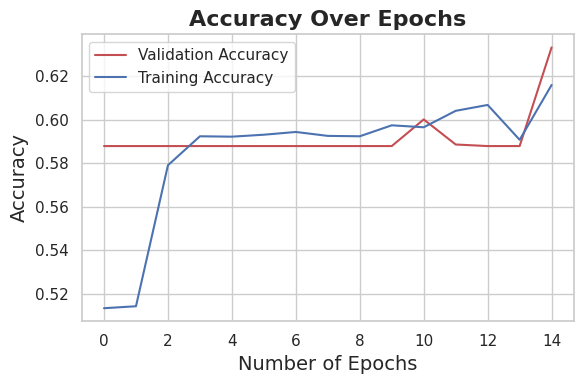

In [313]:
plt.figure(figsize=(6, 4))
# Plot train and validation loss with a color palette
sns.lineplot(x=range(len(history.history['val_accuracy'])), y=history.history['val_accuracy'], color='r', label="Validation Accuracy")
sns.lineplot(x=range(len(history.history['accuracy'])), y=history.history['accuracy'], color='b', label="Training Accuracy")
# Add titles and labels with improved styling
plt.title("Accuracy Over Epochs", fontsize=16, weight='bold')
plt.xlabel("Number of Epochs", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
# Add gridlines and legend
plt.grid(True)
plt.legend()
# Show the plot
plt.tight_layout()
plt.show()

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


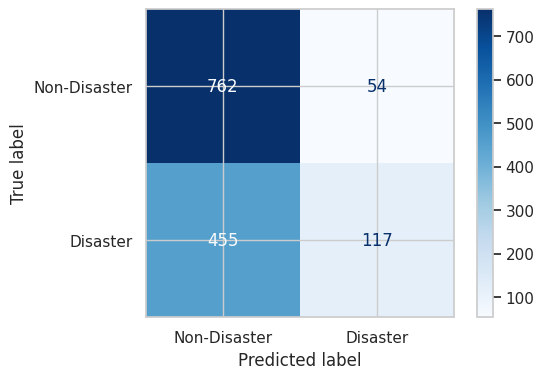

In [316]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Generate predictions
y_pred_probs = model.predict(X_test)  # Replace X_test with your test data
y_pred = (y_pred_probs > 0.5).astype(int)  # Binary classification

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualize confusion matrix
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=['Non-Disaster', 'Disaster'])
disp.plot(cmap=plt.cm.Blues, values_format='d')

# Show the plot
plt.show()

> - **Verdaderos Negativos (TN)**: 762 ejemplos correctamente clasificados como no desastre.

> - **Falsos Positivos (FP):** 54 ejemplos incorrectamente clasificados como desastre.

> - **Falsos Negativos (FN):** 455 ejemplos incorrectamente clasificados como no desastre.

> - **Verdaderos Positivos (TP):** 117 ejemplos correctamente clasificados como desastre.

In [317]:
score = model.evaluate(X_train, y_train, verbose = 0)
print('Accuracy over the training set:', round((score[1]*100), 2), '%')

Accuracy over the training set: 68.07 %


In [318]:
score = model.evaluate(X_test, y_test, verbose = 0)
print('Accuracy over the test set:', round((score[1]*100), 2), '%')

Accuracy over the test set: 63.33 %


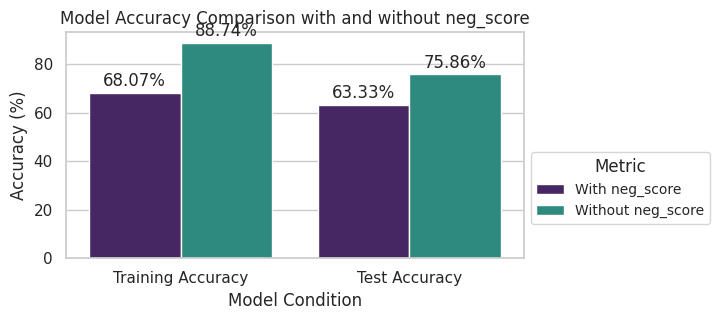

In [335]:

# Accuracy results
accuracies = {
    'With neg_score': {'Training Accuracy': 68.07, 'Test Accuracy': 63.33},
    'Without neg_score': {'Training Accuracy': 88.74, 'Test Accuracy': 75.86}
}

# Convert the accuracy data to a DataFrame for easier plotting with Seaborn
data = pd.DataFrame(accuracies).reset_index().melt(id_vars='index', var_name='Metric', value_name='Accuracy')
data.rename(columns={'index': 'Model Condition'}, inplace=True)

# Set the Seaborn style
sns.set(style="whitegrid")

# Plotting
plt.figure(figsize=(8, 4))
ax = sns.barplot(x='Model Condition', y='Accuracy', hue='Metric', data=data, palette=colors)

# Adding labels and title
ax.set_xlabel('Model Condition')
ax.set_ylabel('Accuracy (%)')
ax.set_title('Model Accuracy Comparison with and without neg_score')

# Adding value labels on bars
def add_value_labels(bars):
    for bar in bars:
        height = bar.get_height()
        if height > 0:  # Only add labels for bars with non-zero height
            ax.annotate(f'{height:.2f}%',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 2),  # 2 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

add_value_labels(ax.patches)

# Add a legend with a specific location and size
ax.legend(title='Metric', loc='best', bbox_to_anchor=(1, 0.5), fontsize='small')

plt.tight_layout(pad=3.0)  # Add padding around the plot

# Show the plot
plt.show()

**Observaciones 💡 -->**

> - La precisión del modelo sobre el conjunto de entrenamiento es del 68.07%, mientras que sobre el conjunto de prueba es del 63.33%. Esto sugiere que el modelo tiene un rendimiento relativamente bueno en los datos de entrenamiento, pero su capacidad de generalización a nuevos datos es algo menor. La diferencia entre la precisión en el conjunto de entrenamiento y el de prueba podría indicar un ligero sobreajuste, donde el modelo se ajusta bien a los datos de entrenamiento pero no generaliza de manera tan efectiva a datos no vistos.

> - Basado en los resultados, la adición de la característica `neg_score` no mejoró el rendimiento del modelo; de hecho, condujo a una disminución en la precisión. Esto podría indicar que neg_score no proporciona información adicional útil o relevante para el modelo. En cambio, puede estar introduciendo ruido o redundanci teniendo impacto negativo en la capacidad para generalizar del modelo.

##### **(3) Prueba de Clasificaciones**

In [319]:
# Define a function to preprocess text
def preprocess_text(text, tokenizer, max_len):
    sequence = tokenizer.texts_to_sequences([text])
    padded_sequence = pad_sequences(sequence, maxlen=max_len)
    return padded_sequence

In [320]:
# Make predictions
def make_predictions(model, tweets):
  for text in tweets:
      padded_sequence = preprocess_text(text, tokenizer, max_len)
      prediction_prob = model.predict(padded_sequence)[0][0]
      prediction = (prediction_prob > 0.5).astype(int)
      print(f"Text: {text}")
      print(f"Probability: {prediction_prob:.4f}")
      print(f"Prediction: {'Disaster' if prediction == 1 else 'Non-Disaster'}\n")

In [321]:
# Test inputs
tweets = [
    "Emergency services are on high alert due to the approaching storm",
    "Our team had a productive meeting this morning discussing new project ideas",
    "He loves playing guitar and composing his own music",
    "Authorities are warning about severe thunderstorms in the area tonight",
    "Firefighters are working hard to contain the wildfires spreading across the region",
]

In [322]:
make_predictions(model=model, tweets=tweets)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 622ms/step
Text: Emergency services are on high alert due to the approaching storm
Probability: 0.4219
Prediction: Non-Disaster

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Text: Our team had a productive meeting this morning discussing new project ideas
Probability: 0.4219
Prediction: Non-Disaster

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Text: He loves playing guitar and composing his own music
Probability: 0.4219
Prediction: Non-Disaster

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Text: Authorities are warning about severe thunderstorms in the area tonight
Probability: 0.4219
Prediction: Non-Disaster

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Text: Firefighters are working hard to contain the wildfires spreading across the region
Probability: 0.4219
Prediction: Non-Disaster



**Observaciones 💡 -->**

> - Las predicciones del modelo con la nueva característica `neg_score` muestran que el modelo está clasificando todos los textos como "Non-Disaster", independientemente del contenido. La probabilidad constante de 0.4219 sugiere que la adición de `neg_score` no está afectando la decisión del modelo de manera positiva. Esto refuerza la idea de que neg_score puede no estar proporcionando información relevante o útil para mejorar la precisión del modelo en la detección de desastres.

<div class="alert alert-block alert-info">
<b>Conclusion: </b> a inclusión de esta variable <b>NO</b> mejoró los resultados del modelo de clasificación.</div>